# Quick start: using Bayesdawn on a simple example

## 0. Import relevant modules

In [33]:
from bayesdawn import datamodel, psdmodel
from bayesdawn.utils import postprocess
import numpy as np
import random
import time
from scipy import signal
from scipy.stats import norm
from matplotlib import pyplot as plt

## 1. Generate example data

To begin with, we generate some simple time series which contains noise and signal. To generate the noise, we start with a white, zero-mean Gaussian noise that we then transform it to obtain a stationary colored noise. This may be either by applying a filter, or by directly applying a specified PSD in frequency space.

The noise PSD model is given by this function:

In [34]:
def psd_function(freq):
    """
    Your PSD function.

    Parameters
    ----------
    freq : ndarray
        Vector of frequency values in Hz.

    Returns
    -------
    psd : ndarray
        Vector of one-sided PSD values computed at freq, expressed in A^2 / Hz, where
        A is the physical unit of the considered time series quantity. 

    """
    result = 1/(1+10000./(1+(freq/2e-2)**(4/np.log10(5))))
    return result

In [35]:
# Explicit LISA noise model
def LISAProposalNoiseAE(f):
    #basic values
    fzero=1e-15
    f[f<fzero]=fzero
    PI=np.pi
    C_SI=299792458.
    OrbitL=2.5e9
    twopifL = 2.*PI*OrbitL/C_SI*f
    f0 = 0;
    alpha = 2
    noise_Sa_a = 9.e-30
    noise_Soms_d = pow((10e-12), 2)
    #acceleration noise
    Sa_a = noise_Sa_a * (1.0 + pow(0.4e-3/f, 2)) * (1.0 + pow((f/8e-3), 4));
    Sa_d = Sa_a * pow(2.*PI*f, -4)
    Sa_nu = Sa_d * pow(2.*PI*f/C_SI, 2)
    Spm = Sa_nu
    Spm = Spm * (1. + pow(f0/f, alpha))
    #optical path noise
    Soms_d = noise_Soms_d * (1. + pow(2.e-3/f, 4));
    Soms_nu = Soms_d * pow(2.*PI*f/C_SI, 2);
    Sop = Soms_nu;
    Ampl = 1.28265531e-44; alpha = 1.62966700e+00; fr2 = 4.81078093e-04; af1 = -2.23499956e-01; bf1 = -2.70408439e+00; afk = -3.60976122e-01; bfk = -2.37822436e+00;
    #galaxy noise
    WDduration=3
    log10WDduration = np.log10(WDduration);
    fr1 = pow(10., (af1*log10WDduration + bf1));
    fknee = pow(10., (afk*log10WDduration + bfk));
    galshape = Ampl * np.exp(-pow((f/fr1), alpha)) * (pow(f, -7./3.))*0.5*(1.0 + np.tanh(-(f-fknee)/fr2));
    galnoise = 3*twopifL*twopifL * galshape
    #combined for A/E
    c2 = np.cos(twopifL);
    c4 = np.cos(2*twopifL);
    s2 = np.sin(twopifL);
    return 2*s2*s2 * (4 * (2*(3. + 2*c2 + c4)*Spm + (2 + c2)*Sop) + galnoise)

In [3]:
# Choose size of data
upscale_fac = 3
n_data = 2**14*upscale_fac
# Set sampling frequency
fs = 1.0*upscale_fac
# Generate Gaussian white noise
noise = np.random.normal(loc=0.0, scale=1.0, size = n_data)
# Transform to colored noise
if(False): #Choose True or False option
    # Apply filtering to turn it into colored noise
    noisePSDfunc=None
    r = 0.01
    b, a = signal.butter(3, 0.1/0.5, btype='high', analog=False, fs=fs)
    n = (signal.lfilter(b,a, noise, axis=-1, zi=None) + noise*r) * np.sqrt(fs)
else:
    #Color according to a specified PSD
    #noisePSDfunc=lambda f: 1/(1+10000./(1+(f/2e-2)**(4/np.log10(5))))
    noisePSDfunc=lambda f: LISAProposalNoiseAE(f/100)*1e42
    f = np.fft.rfftfreq(n_data) * fs
    #now we use noise as noise for Re/Im parts of white FFT
    #Need to check that this correctly assumes a "one-sided" PSD
    n_fft=noise[0:n_data//2+1]+0*1j #complex white noise real part (n_data assumed even )
    n_fft[1:]=n_fft[1:]+1j*noise[n_data//2:] #complex white noise imag part (zeros at ends!)
    sqrtS=np.sqrt(np.apply_along_axis(noisePSDfunc,0,f))
    print('2df',f[2]-f[0],1/(n_data*fs/2))
    n_fft=sqrtS*n_fft*np.sqrt(n_data*fs/4)
    n=np.fft.irfft(n_fft)

2df 0.0001220703125 1.3563368055555555e-05


Then we need a deterministic signal to add. We choose a sinusoid with some frequency $f_0$ and amplitude $a_0$:

In [4]:
# Creation of deterministic signal
t = np.arange(0, n_data) / fs
f0 = 1e-2
a0 = 5e-3
s = a0 * np.sin(2 * np.pi * f0 * t)
# Adding signal to noise
y = s + n

Now assume that some data are missing, i.e. the time series is cut by random gaps. The pattern is represented by a mask vector with entries equal to 1 when data is observed, and 0 otherwise:

In [5]:
mask = np.ones(n_data)
# n_gaps = 30
n_gaps = 5
gapstarts = (n_data * np.random.random(n_gaps)).astype(int)
gaplength = 100*fs #Gap is a fixed size in time.
gapends = (gapstarts+gaplength).astype(int)
for k in range(n_gaps): mask[gapstarts[k]:gapends[k]]= 0
# Masked data:
y_masked = mask * y

## 2. Define your PSD function and embed it in a class

We assume that we know exaclty the noise PSD model, given by this function:

In [6]:
def psd_function(freq):
    """
    Your PSD function.

    Parameters
    ----------
    freq : ndarray
        Vector of frequency values in Hz.

    Returns
    -------
    psd : ndarray
        Vector of one-sided PSD values computed at freq, expressed in A^2 / Hz, where
        A is the physical unit of the considered time series quantity. 

    """
    if noisePSDfunc is None:
        w, h = signal.freqz(b, a, worN=freq, plot=None, fs=fs)
        result = 2 * (np.abs(h)**2 + np.abs(r)**2)
    else:
        result = noisePSDfunc(freq)
    return result

## Check that the PSD function is consistent with the data

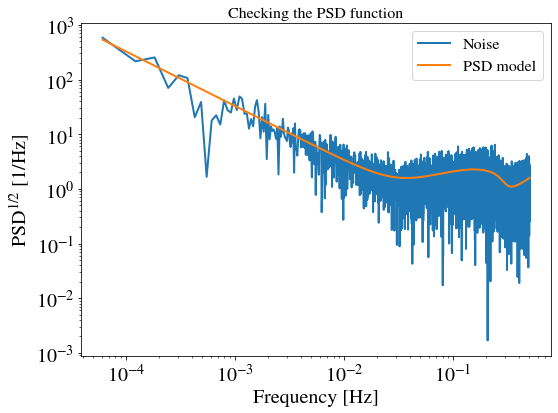

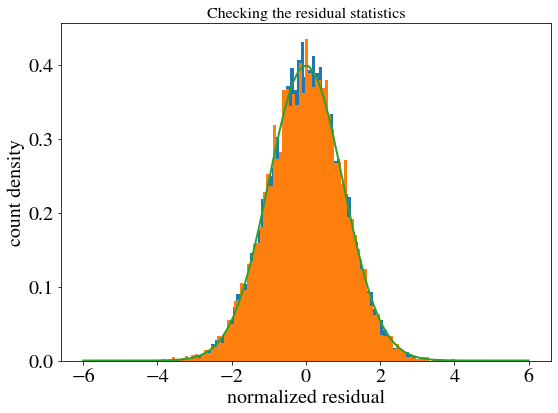

In [7]:
f = np.fft.rfftfreq(n_data) * fs
n_fft = np.fft.rfft(n)
psd = psd_function(f[f>0])
scalefac=np.sqrt(2 / (n_data*fs))
# Load plotting configuration
postprocess.plotconfig(lbsize=20, lgsize=16, autolayout=True, figsize=(8, 6),
                       ticklabelsize=20)
# Plot data against PSD
fig, ax = plt.subplots()
ax.set_title(r"Checking the PSD function")
ax.set_xlabel(r"Frequency [Hz]")
ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
ax.loglog(f[f>0], np.abs(n_fft[f>0]) * scalefac, label="Noise")
ax.loglog(f[f>0], np.sqrt(psd), label="PSD model")
plt.legend()
plt.show()
#Check the statistics on the residual
df=fs/n_data
nbins=int(np.sqrt(len(n_fft)))
plt.hist(n_fft.real[f>0]*scalefac/np.sqrt(psd/2),bins=nbins,density=True,label="real part")
plt.hist(n_fft.imag[f>0]*scalefac/np.sqrt(psd/2),bins=nbins,density=True,label='imag part')
x=np.linspace(-6,6,nbins)
plt.plot(x,norm.pdf(x))
plt.title(r"Checking the residual statistics")
plt.xlabel(r"normalized residual")
plt.ylabel(r"count density") 
plt.show()

In [8]:
# Embed the PSD function in a class
class MyPSD(psdmodel.PSD):

    def __init__(self, n_data, fs):

        psdmodel.PSD.__init__(self, n_data, fs, fmin=None, fmax=None)

    def psd_fn(self, x):

        return psd_function(x)

In [9]:
# Instantiate the psd class
psd_cls = MyPSD(n_data, fs)

## 3. Instantiate the imputation class

Then, from the signal and noise models, we can instantiate the GaussianStationaryProcess class from the datamodel module:

In [10]:
# instantiate imputation class
#imp_cls = datamodel.GaussianStationaryProcess(s, mask, psd_cls, method='nearest', na=50*fs, nb=50*fs)
imp_cls = datamodel.GaussianStationaryProcess(s, mask, psd_cls, method='woodbury', na=150*fs, nb=150*fs)
# perform offline computations
imp_cls.compute_offline()
# If you want to update the deterministic signal (the mean of the Gaussian process)
#imp_cls.update_mean(s)
# If you want to update the PSD model
#imp_cls.update_psd(psd_cls)

Computation of autocovariance + PSD took 0.00982356071472168
Start Toeplitz system precomputations...
shape of c_mat is (16384, 300)


## 4. Perform missing data imputation

We can then reconstruct the missing data with the `impute` method of the GaussianStationaryProcess class:

In [42]:
# Imputation of missing data by randomly drawing from their conditional distribution
t1 = time.time()
y_rec_draw = imp_cls.impute(y_masked, draw=True)
t2 = time.time()
print("Missing data imputation took " + str(t2-t1))

Build preconditionner...
Preconditionner built.
successful exit!
Value of || A * x - b ||/||b|| at exit:
4.2212775110680056e-07
Missing data imputation took 2.8833959102630615


In [11]:
# Imputation of missing data by randomly drawing from their conditional distribution
t1 = time.time()
y_rec = imp_cls.impute(y_masked, draw=False)
t2 = time.time()
print("Missing data imputation took " + str(t2-t1))

Missing data imputation took 0.022762537002563477


To see whether the imputation gives statisfactory statistics, we will compare the imputed data to the original one in Fourier domain. We start by Fourier-transforming the data:

In [12]:
# Fourier transform the results and the input data
y_fft = np.fft.rfft(y)
y_masked_fft = np.fft.rfft(y_masked)
y_rec_fft = np.fft.rfft(y_rec)
y_rec_draw_fft = np.fft.rfft(y_rec_draw)

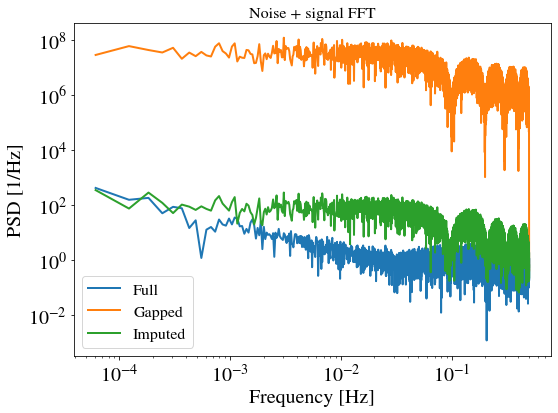

In [13]:
# Plot results
fig, ax = plt.subplots()
ax.set_title(r"Noise + signal FFT")
ax.set_xlabel(r"Frequency [Hz]")
ax.set_ylabel(r"PSD [1/Hz]") 
ax.loglog(f[f>0], np.abs(y_fft[f>0]) * scalefac, label="Full")
ax.loglog(f[f>0], np.abs(y_masked_fft[f>0]) * scalefac, label="Gapped")
ax.loglog(f[f>0], np.abs(y_rec_fft[f>0]) * scalefac, label="Imputed (expectation)")
# ax.loglog(f[f>0], np.abs(y_rec_draw_fft[f>0]) * scalefac, label="Imputed (draw)")
plt.legend()
plt.show()

## 5. Comparing time series

0.9794774434521878


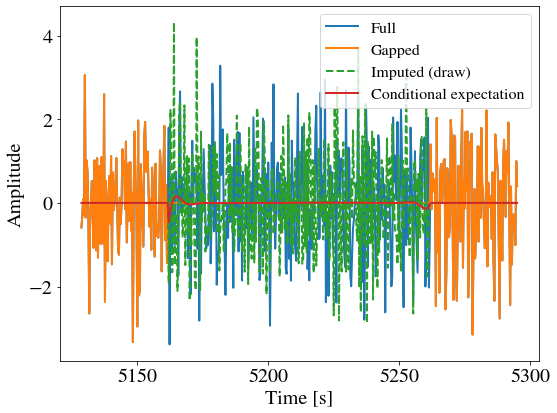

In [46]:
k = 0
delta = 100
inds = np.arange(gapstarts[k]-delta, gapends[k]+delta)
ym = y * (1 - mask)
ym_rec_draw = y_rec_draw * (1 - mask)
var_rec_draw = np.var(ym_rec_draw[mask==0])
var_original = np.var(ym[mask==0])
print(var_rec_draw / var_original)

fig, ax = plt.subplots()
# ax.set_title(r"Noise + signal FFT")
ax.set_xlabel(r"Time [s]")
ax.set_ylabel(r"Amplitude") 
ax.plot(t[inds], y[inds], label="Full")
ax.plot(t[inds], y_masked[inds], label="Gapped")
ax.plot(t[inds], ym_rec_draw[inds], label="Imputed (draw)", linestyle='dashed')
ax.plot(t[inds], y_rec[inds]* (1 - mask[inds]), label="Conditional expectation")
plt.legend()
plt.show()

In [47]:
print(imp_cls.autocorr[0] / np.var(y) )

1.0039916185919457
